In [7]:
import matplotlib.pyplot as plt
import torch as t
from m4.data.dataset_extractor import M4DatasetExtractor, M4DatasetGroup
from fcast.utils.serialization import deserialize
from m4.pipeline.forecaster.m4_baselines import theta
from fcast.pipeline.transformation.scaling import Scaling
from m4.pipeline.model.lstm import UniqueLSTM
from fcast.domain.dataset import Dataset
from m4.pipeline.adaptors import dataframe_to_tensor, default_torch_device, tensor_to_dataframe
from pandas import DataFrame

extractor = M4DatasetExtractor(dataset_path='/projects/eai-m4/dataset', group=M4DatasetGroup.daily)
train_dataset = extractor.training_set()
ts = train_dataset[1]
min_v = float(ts.data.min(axis=0))
max_v = float(ts.data.max(axis=0))
denominator = max_v - min_v
scaled_ts = ts.data.apply(lambda v: (v - min_v) / denominator)
# scaled_ds = Dataset(name='ts_1', ts_list=[scaled_ts])

# lstm = UniqueLSTM(num_features=1,
#                   hidden_size=100,
#                   num_layers=1,
#                   output_size=1,
#                   loss_function=t.nn.MSELoss(),
#                   learning_rate=0.0001,
#                   max_chunk_size=2000
#                  )       


### Input

In [8]:
original_shape = scaled_ts.shape
inp_ts = scaled_ts[:-1]
inp_shape = inp_ts.shape
ts_tensor = t.unsqueeze(dataframe_to_tensor(inp_ts), 0)

print(f'original: {original_shape}\ninput ts shape: {inp_shape}\ninput shape: {ts_tensor.shape}')

original: (1006, 1)
input ts shape: (1005, 1)
input shape: torch.Size([1, 1005, 1])


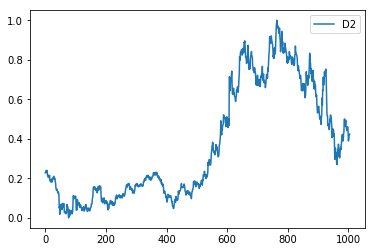

In [9]:
tensor_to_dataframe(ts_tensor.squeeze(0), scaled_ts.columns).plot()

### Model

In [16]:
class TSLSTM(t.nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = t.nn.LSTM(input_size=1,
                              hidden_size=hidden_size,
                              num_layers=num_layers,
                              batch_first=True  # expects input as (batch, seq, features)
                             )
        self.output_layer = t.nn.Linear(in_features=hidden_size, out_features=1)                          
        
    def update(self, inp):
        optim = t.optim.Adadelta(self.parameters())
        loss = t.nn.L1Loss(reduction='elementwise_mean')
        prediction = self(inp[:, :-1, :])
        loss_fn = loss(prediction, inp[:, 1:, :])
        loss_fn.backward() # calculates gradients for each model parameter (looking at prediction)
        optim.step() # updates weights
        return float(loss_fn)
                        
    def forward(self, inp):
        output, _ = self.lstm(inp)
        result = self.output_layer(output)
        return result
        

### Prediction

ouput tensor shape: torch.Size([1, 1005, 1])
output ts shape: (1005, 1)


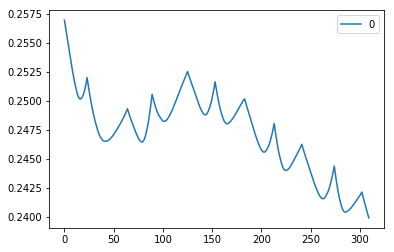

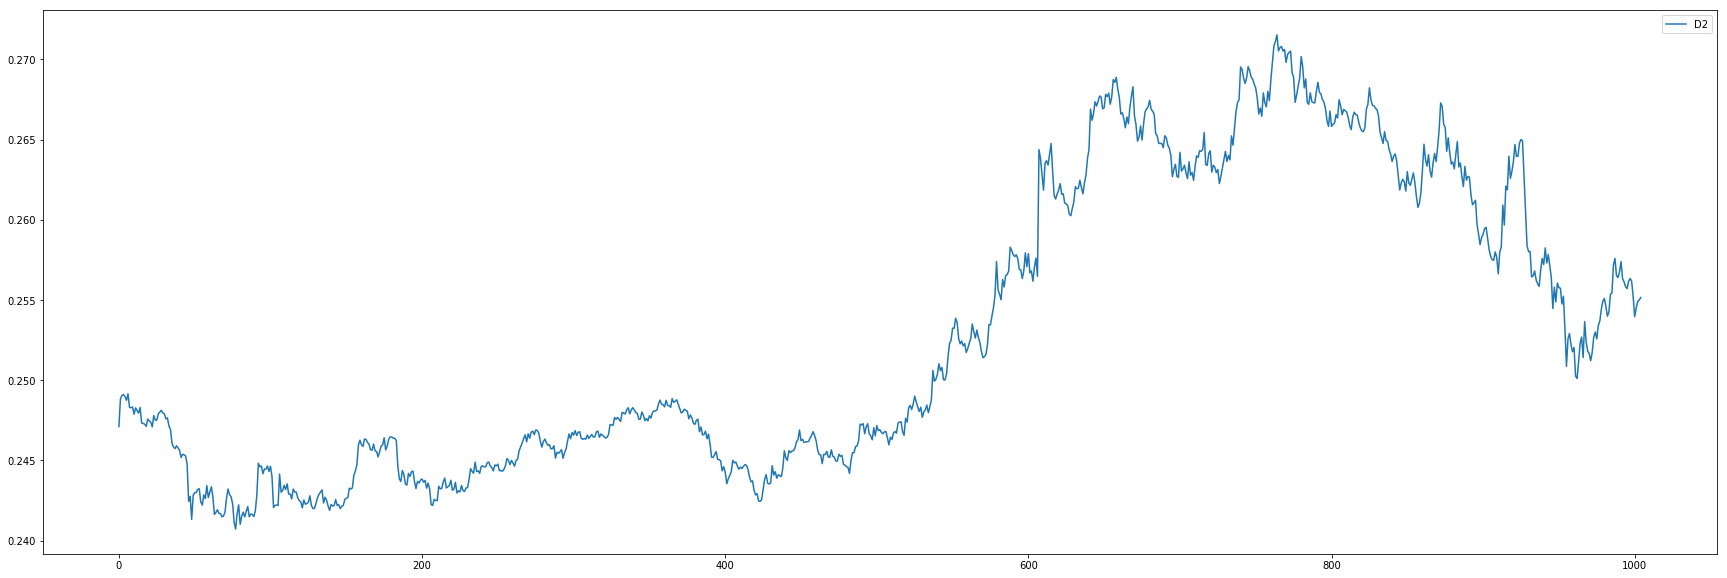

In [20]:
lstm = TSLSTM(hidden_size=1, num_layers=1)

losses = []
loss = float('inf')
while loss > 0.240 or len(losses) < 300:
    loss = lstm.update(ts_tensor)
    losses.append(loss)
    
output_tensor = lstm(ts_tensor)
output_ts = tensor_to_dataframe(t.squeeze(output_tensor, 0), scaled_ts.columns)

print(f'ouput tensor shape: {output_tensor.shape}\noutput ts shape: {output_ts.shape}')
DataFrame(losses).plot()
output_ts.plot(figsize=(30,10))

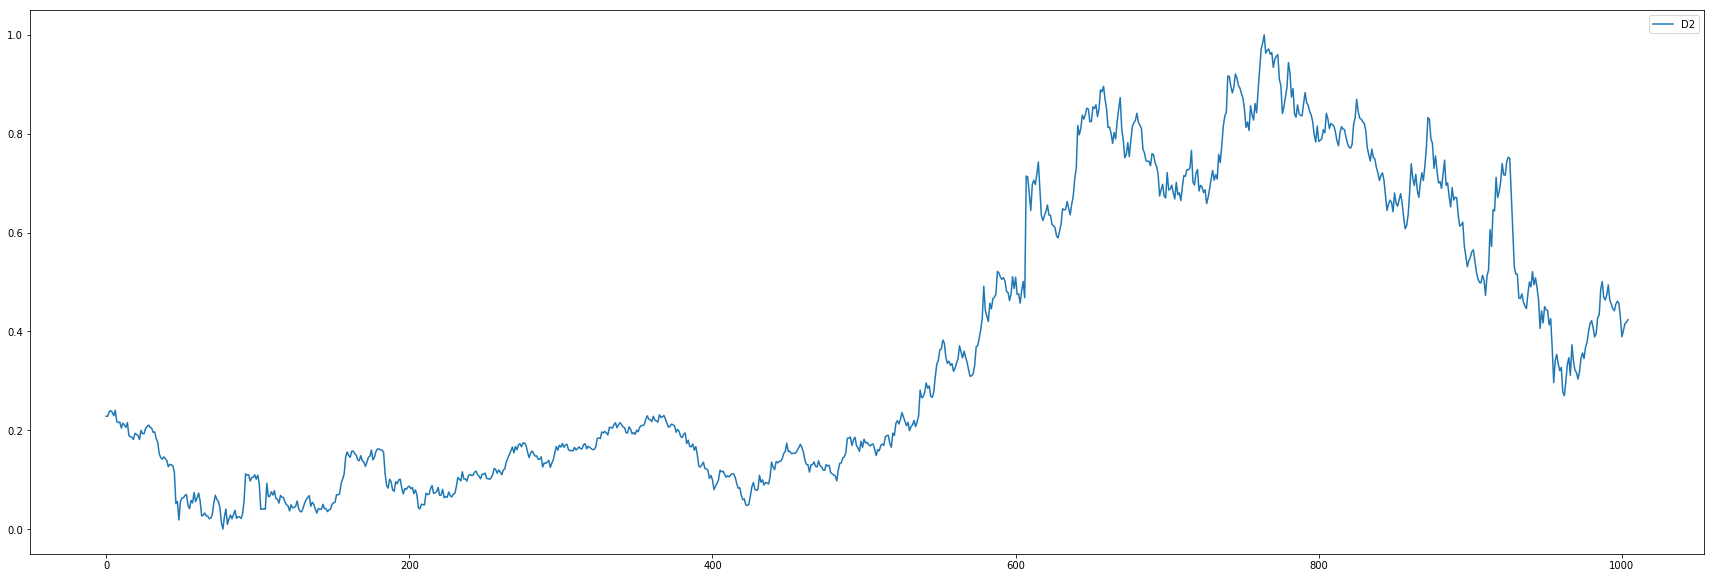

In [67]:
inp_ts.plot(figsize=(30,10))

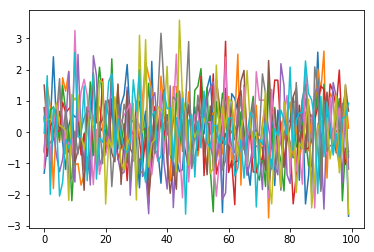

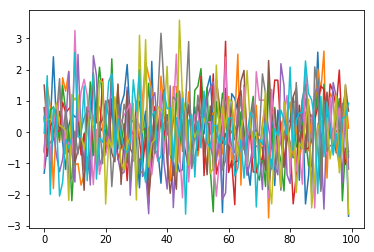

In [47]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.plot(pl.randn(100))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)

In [66]:
inp = dataframe_to_tensor(scaled_ts[:-1])
lstm._lstm.reset_state()
tensor_to_dataframe(lstm._lstm(inp), scaled_ts.data.columns).plot(figsize=(30,10))
plt.show()

AttributeError: 'TSLSTM' object has no attribute '_lstm'

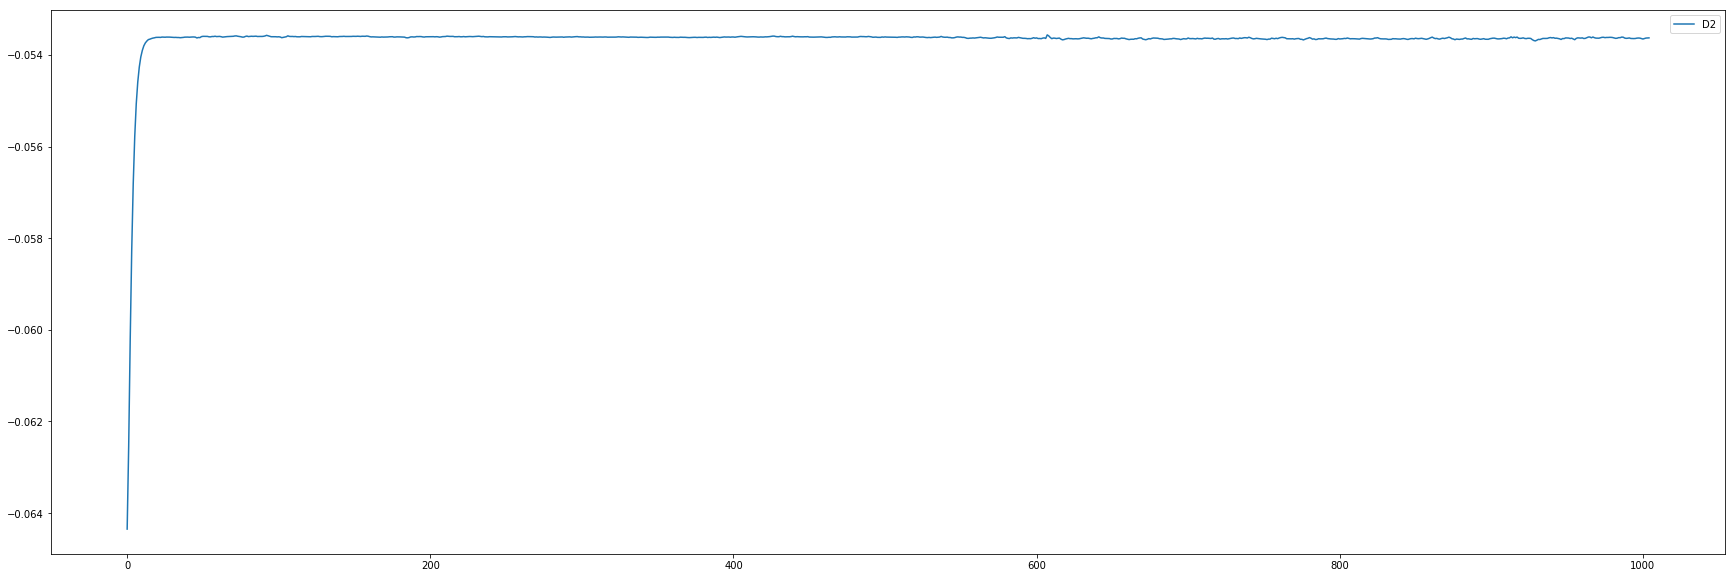

In [26]:
loss = lstm.update(scaled_ds)
inp = dataframe_to_tensor(scaled_ts.data[:-1])
lstm._lstm.reset_state()
tensor_to_dataframe(lstm._lstm(inp), scaled_ts.data.columns).plot(figsize=(30,10))
plt.show()

In [174]:
loss

0.7763291597366333

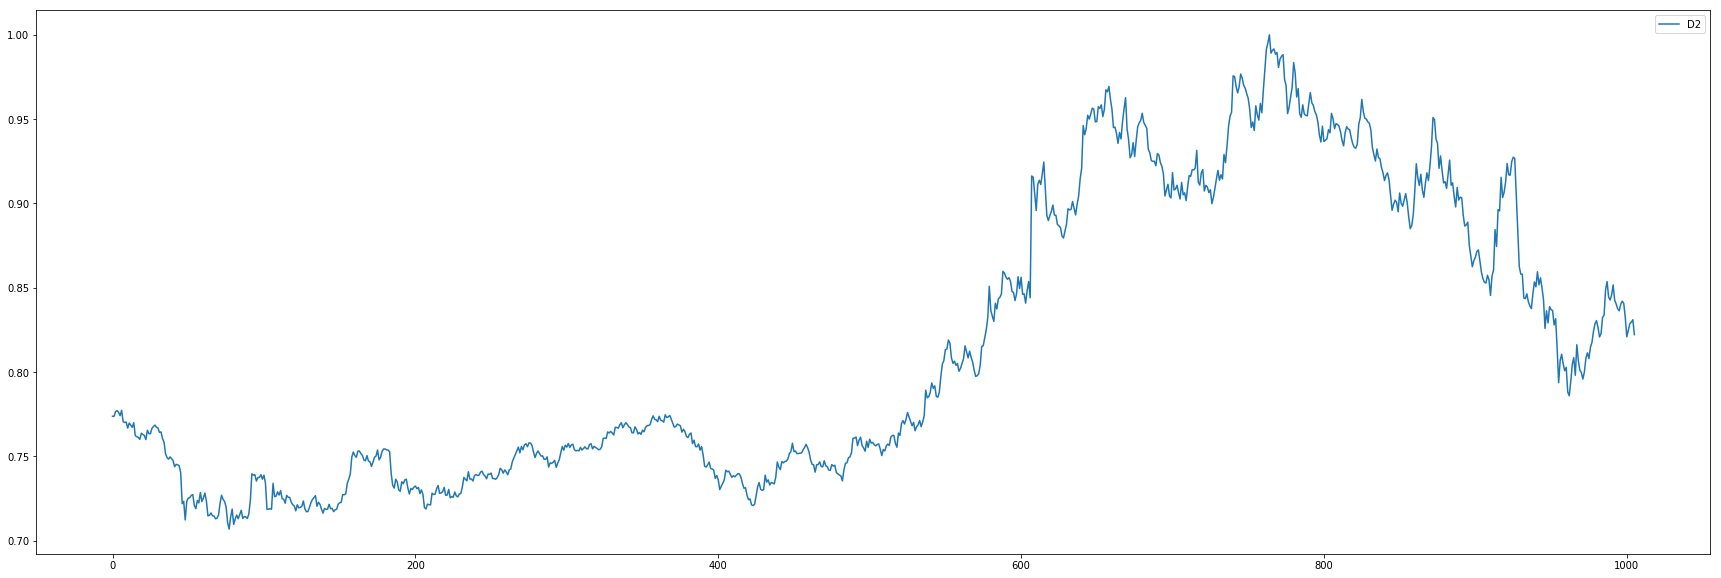

In [56]:
scaled_ts.data.plot(figsize=(30,10))

In [21]:
output_ts

,D2
0,0.768826
1,0.768823
2,0.768823
3,0.768823
4,0.768823
5,0.768823
6,0.768823
7,0.768822
8,0.768822
9,0.768822


In [23]:
inp_ts

,D2
0,0.773792
1,0.773820
2,0.776562
3,0.777144
4,0.776174
5,0.774152
6,0.777310
7,0.770607
8,0.770081
9,0.770386
